<a href="https://colab.research.google.com/github/myshendrik/Heron-Hunter-/blob/main/notebooks/train-yolo11-object-detection-on-custom-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Object Detection on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Jun 19 11:27:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [3]:
%pip install "ultralytics<=8.3.40" supervision roboflow
# prevent ultralytics from tracking your activity
!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.8/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [4]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

100% 5.35M/5.35M [00:00<00:00, 202MB/s]
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 104k/104k [00:00<00:00, 72.0MB/s]
image 1/1 /content/dog.jpeg: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 46.1ms
Speed: 13.6ms preprocess, 46.1ms inference, 378.6ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

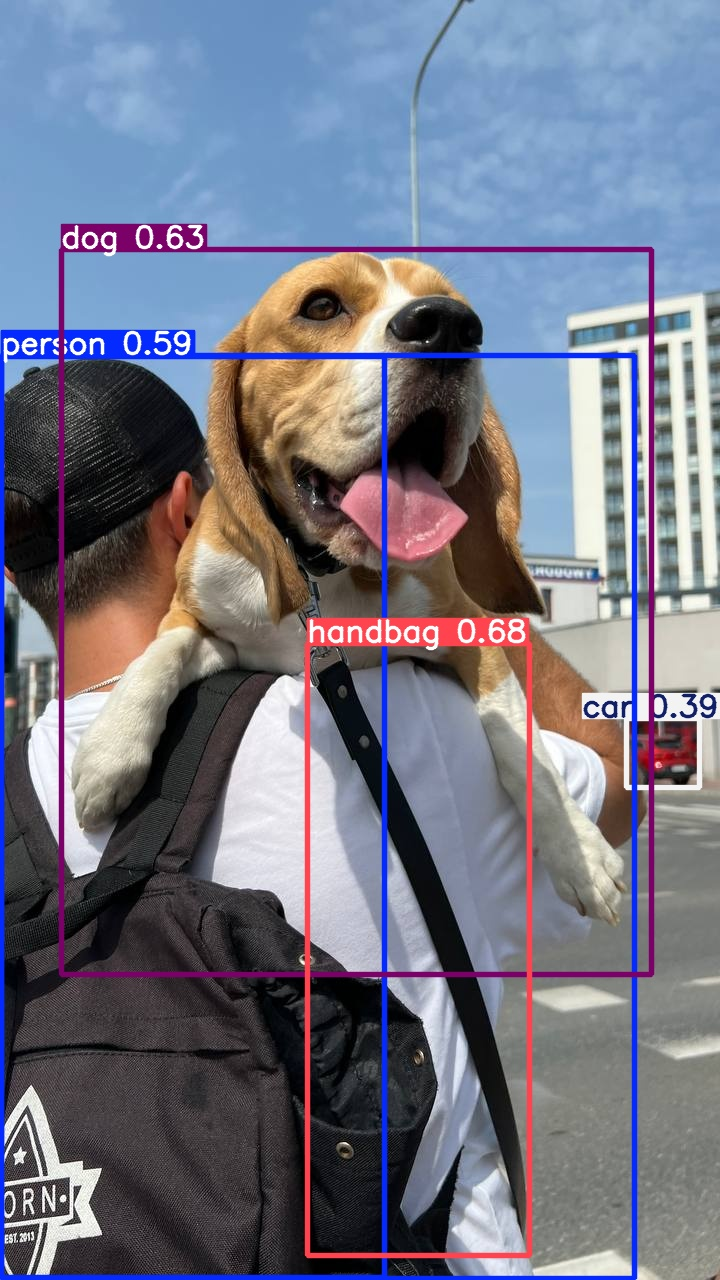

In [5]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/dog.jpg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [6]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 56.1ms
Speed: 3.3ms preprocess, 56.1ms inference, 153.1ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [7]:
result.boxes.xyxy

tensor([[3.0705e+02, 6.4341e+02, 5.2919e+02, 1.2558e+03],
        [6.1400e+01, 2.4994e+02, 6.5165e+02, 9.7412e+02],
        [1.7803e+00, 3.5551e+02, 6.3404e+02, 1.2788e+03],
        [1.1933e+00, 3.5620e+02, 3.8455e+02, 1.2776e+03],
        [6.2615e+02, 7.1818e+02, 6.9975e+02, 7.8754e+02]], device='cuda:0')

In [8]:
result.boxes.conf

tensor([0.6832, 0.6284, 0.5941, 0.3923, 0.3875], device='cuda:0')

In [9]:
result.boxes.cls

tensor([26., 16.,  0.,  0.,  2.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [10]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

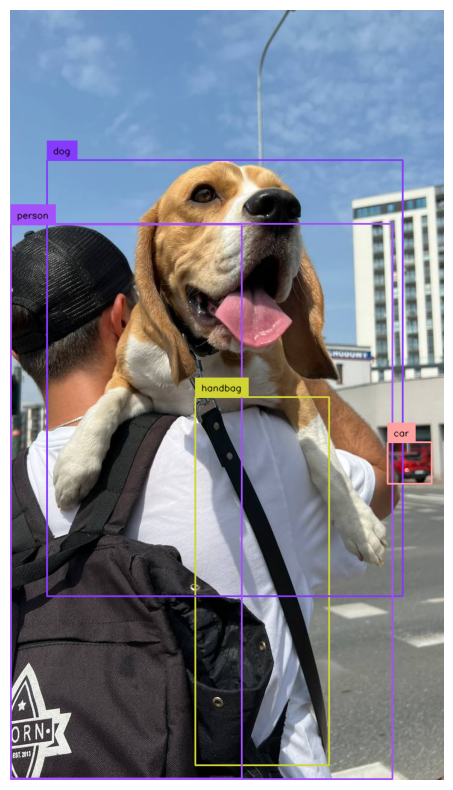

In [11]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [12]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("workspace-twanbruurs")
project = workspace.project("blue-heron-raspberry")
version = project.version(1)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format


Extracting Dataset Version Zip to Blue-Heron-Raspberry-1 in yolov11:: 100%|██████████| 3100/3100 [00:00<00:00, 5005.40it/s]


## Custom Training

In [13]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=25 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 67.9MB/s]
New https://pypi.org/project/ultralytics/8.3.156 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/Blue-Heron-Raspberry-1/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=Fa

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [14]:
!ls {HOME}/runs/detect/train/

args.yaml					    train_batch1020.jpg
confusion_matrix_normalized.png			    train_batch1021.jpg
confusion_matrix.png				    train_batch1022.jpg
events.out.tfevents.1750333186.d62f1328bebd.7007.0  train_batch1.jpg
F1_curve.png					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
P_curve.png					    val_batch1_labels.jpg
PR_curve.png					    val_batch1_pred.jpg
R_curve.png					    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


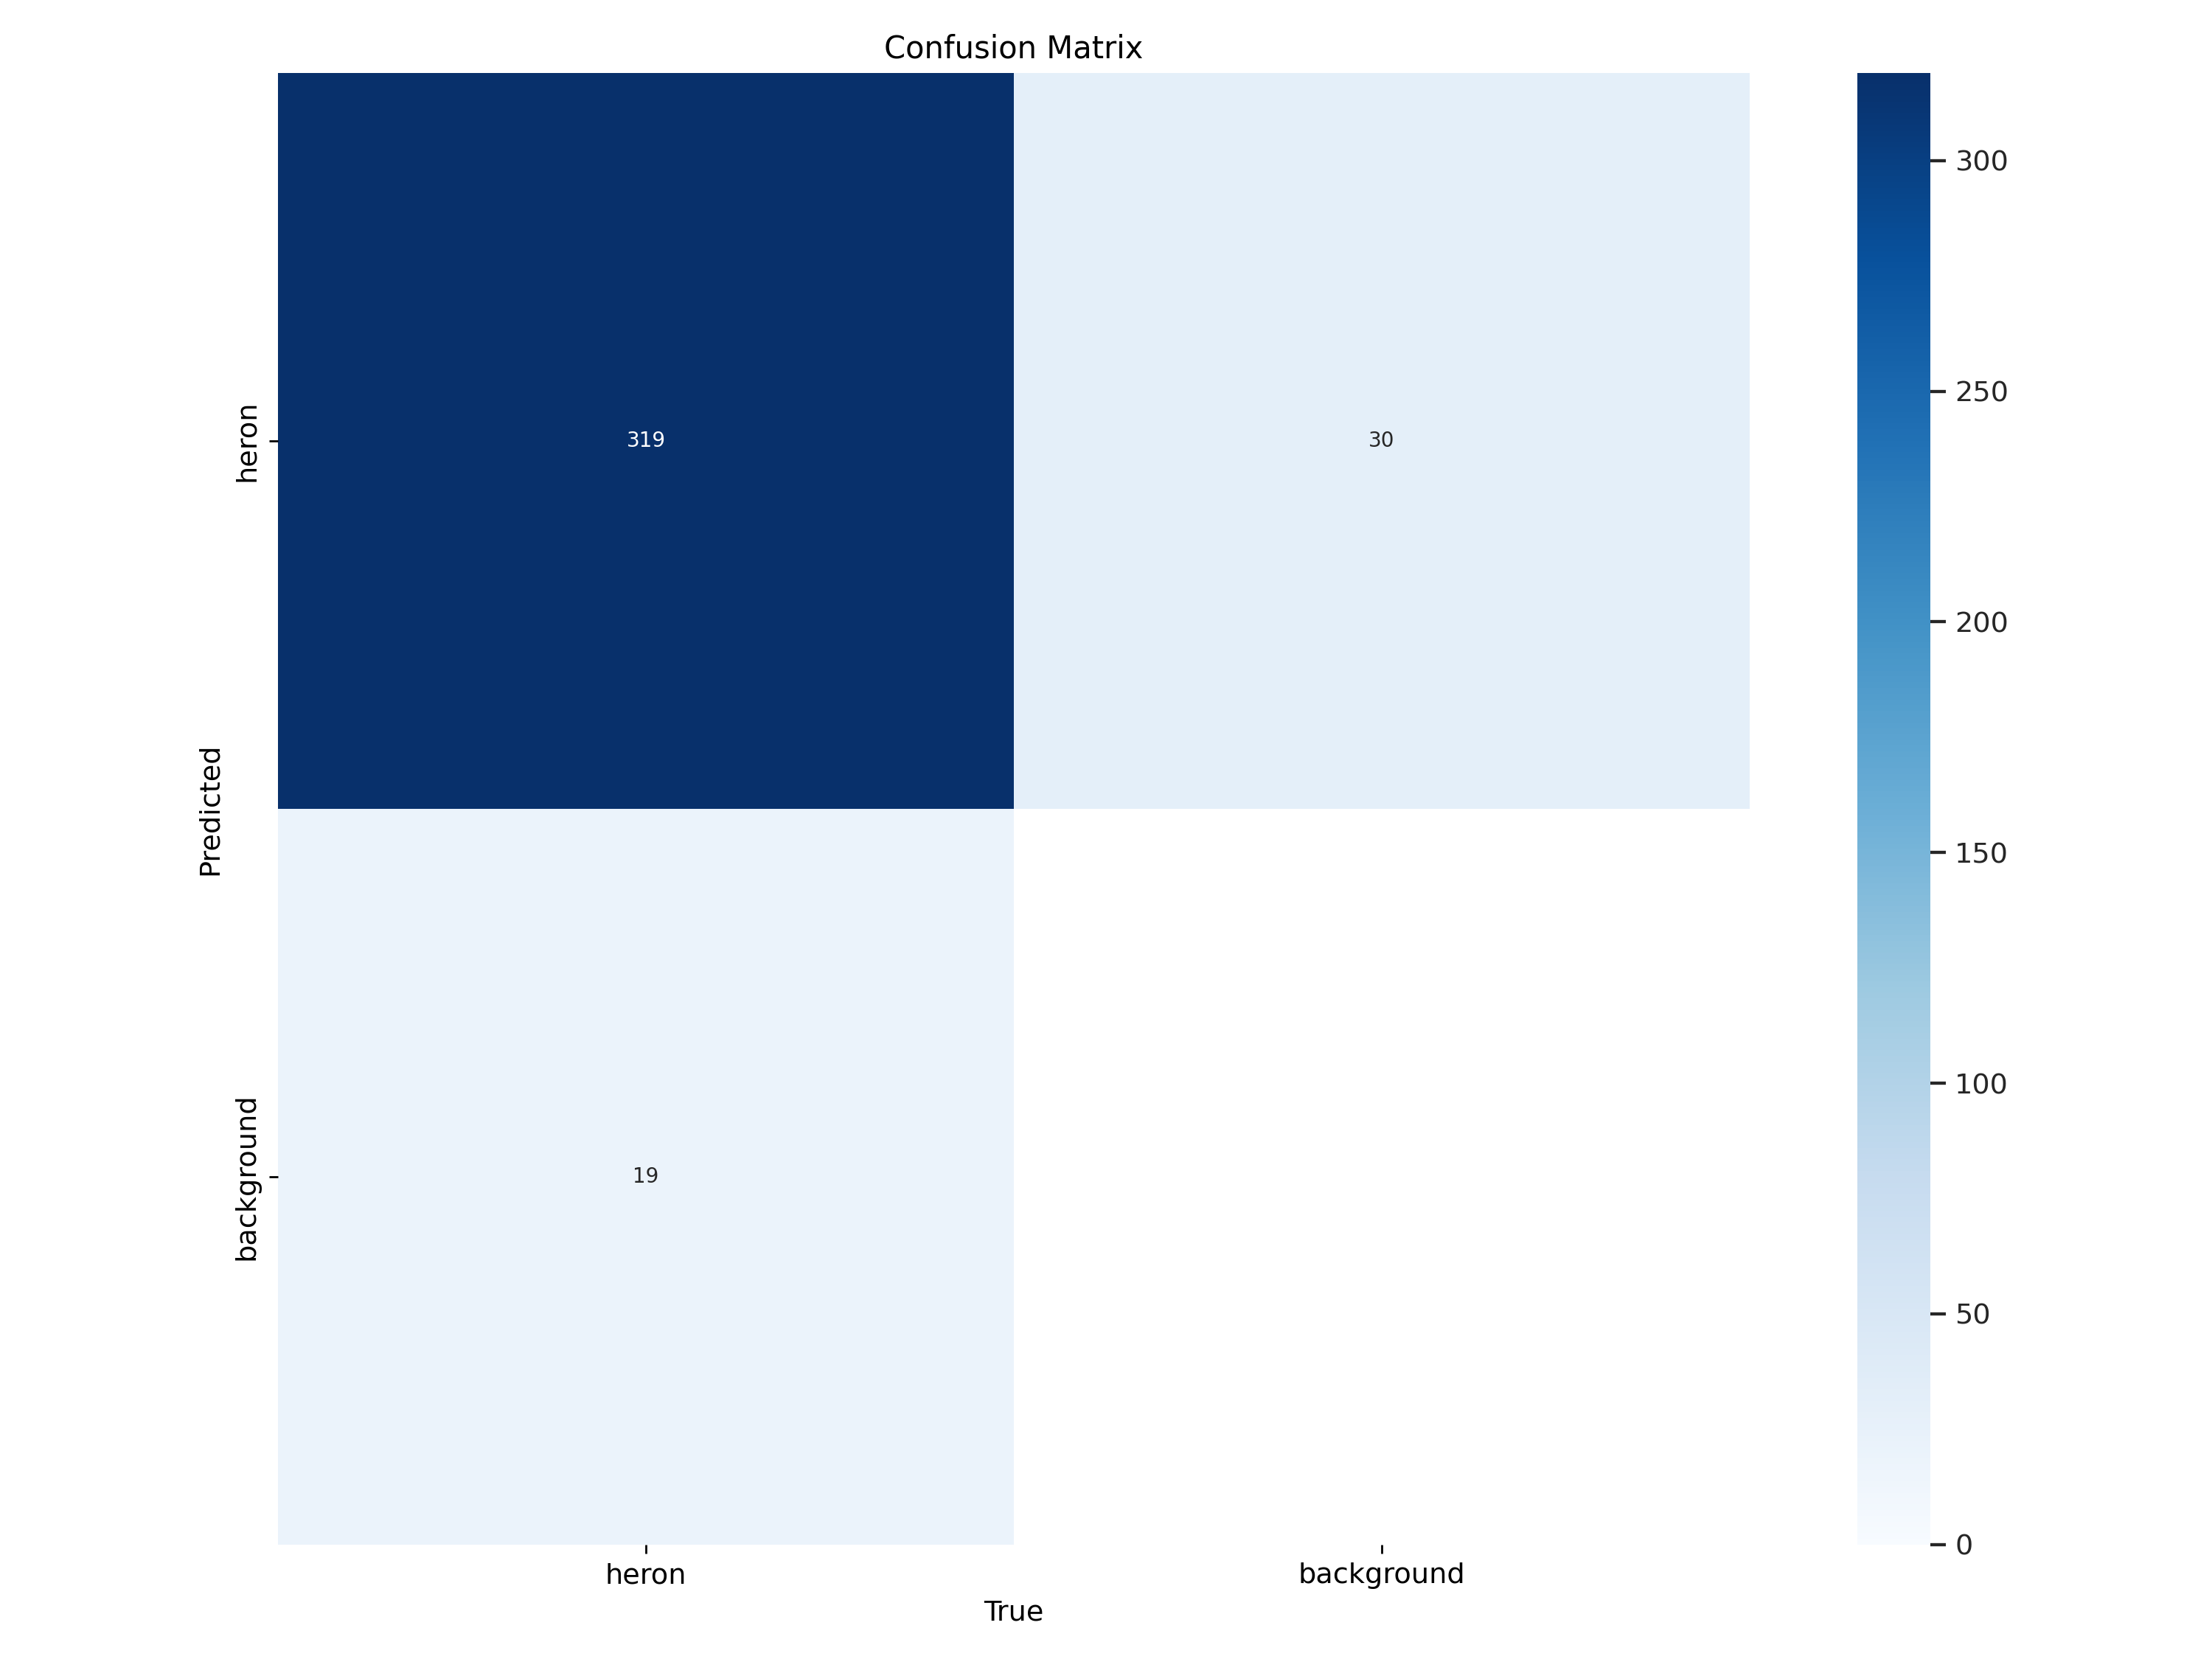

In [15]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

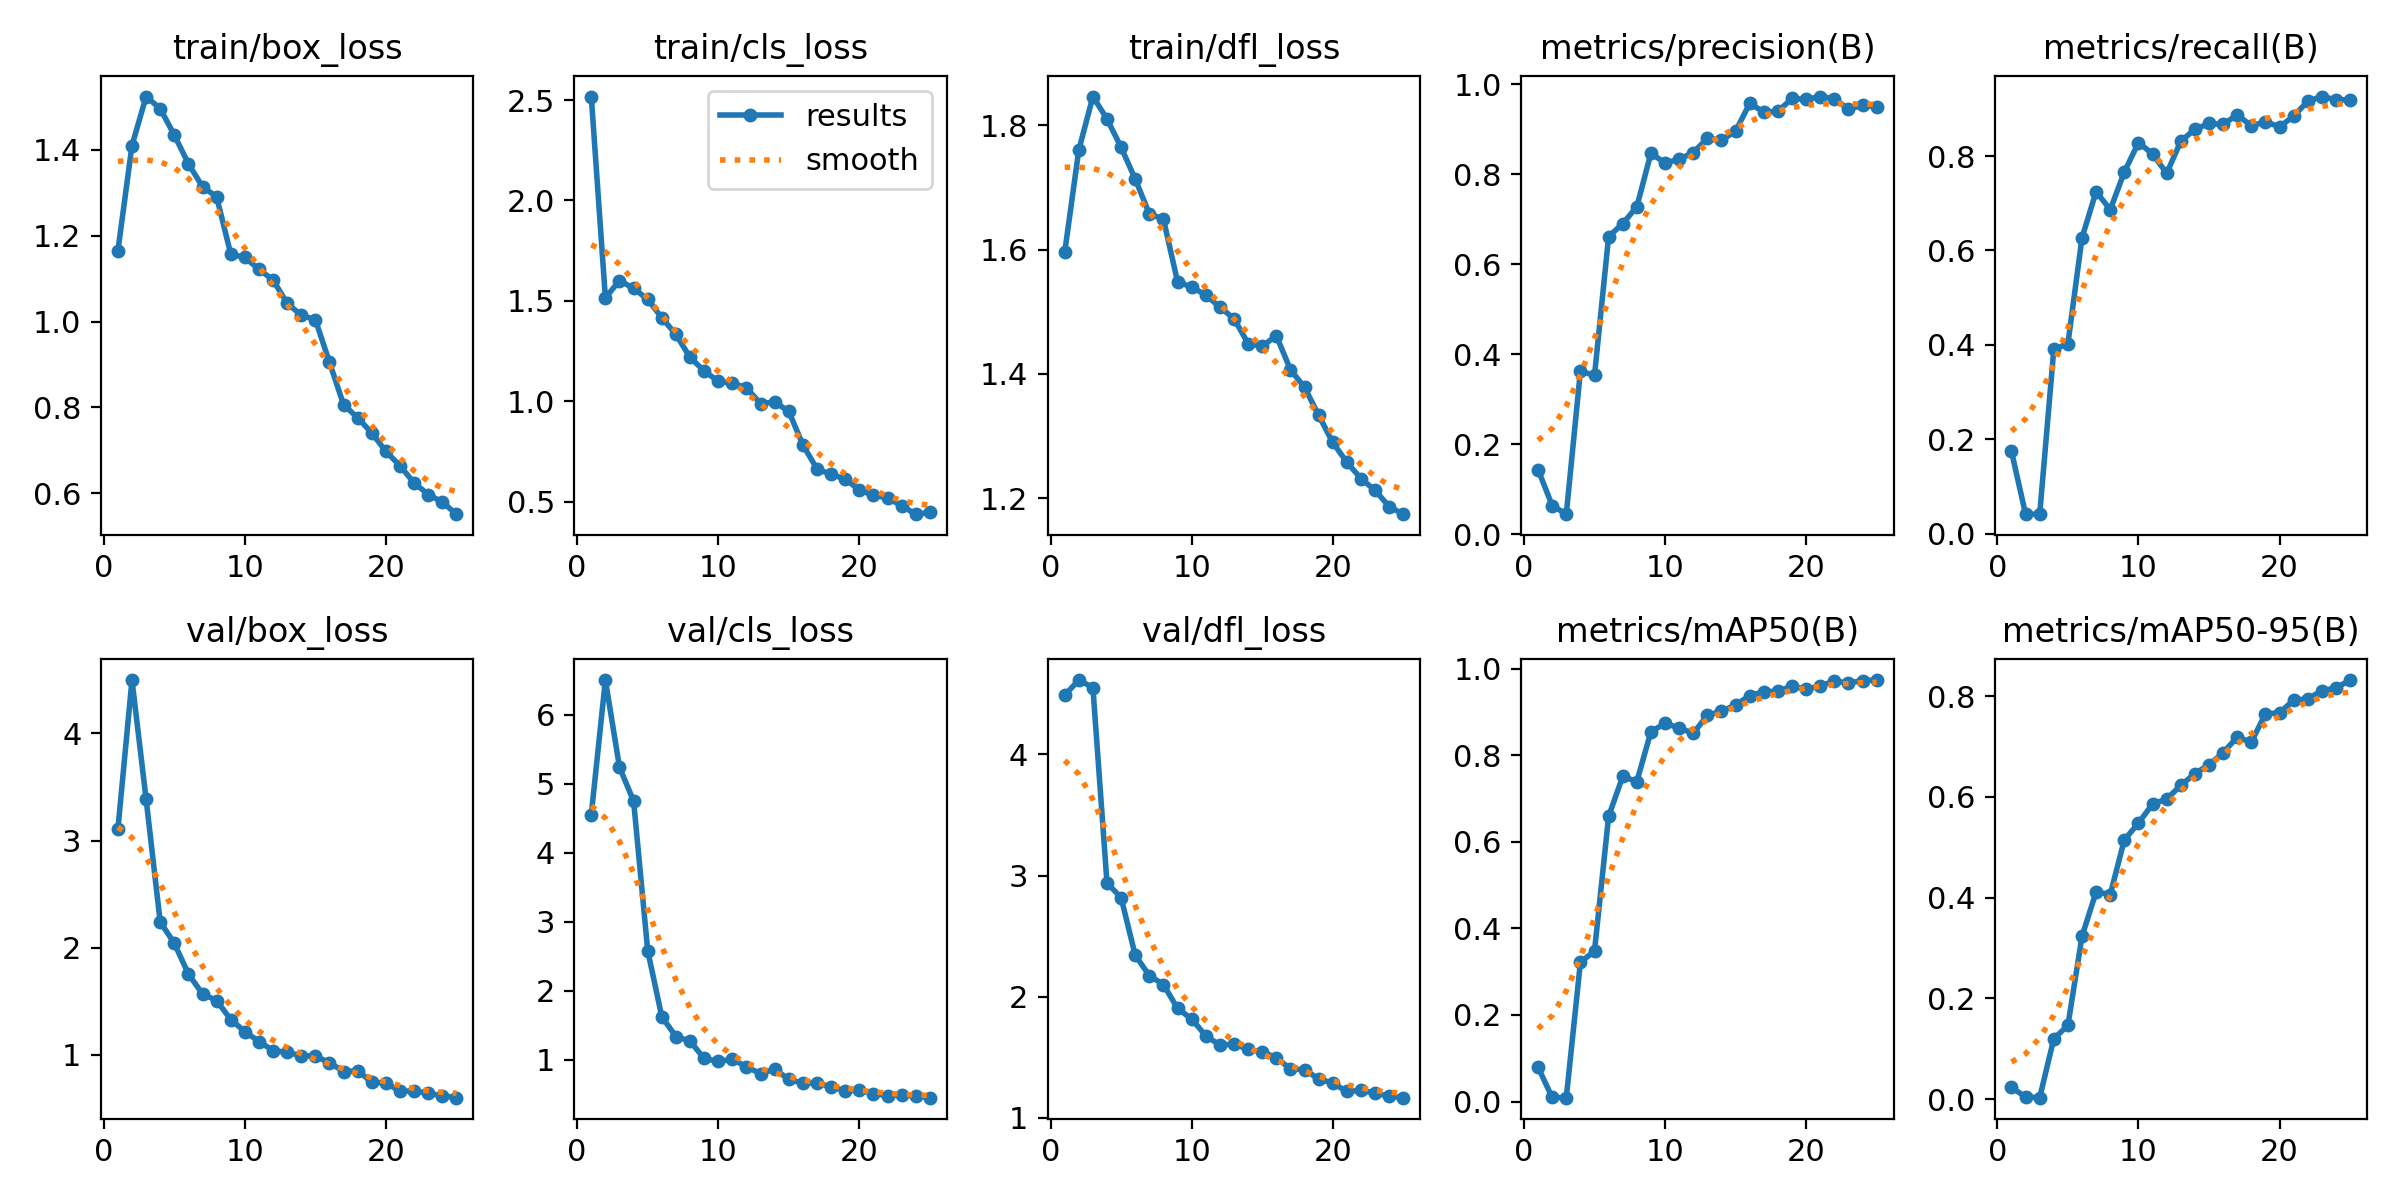

In [16]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

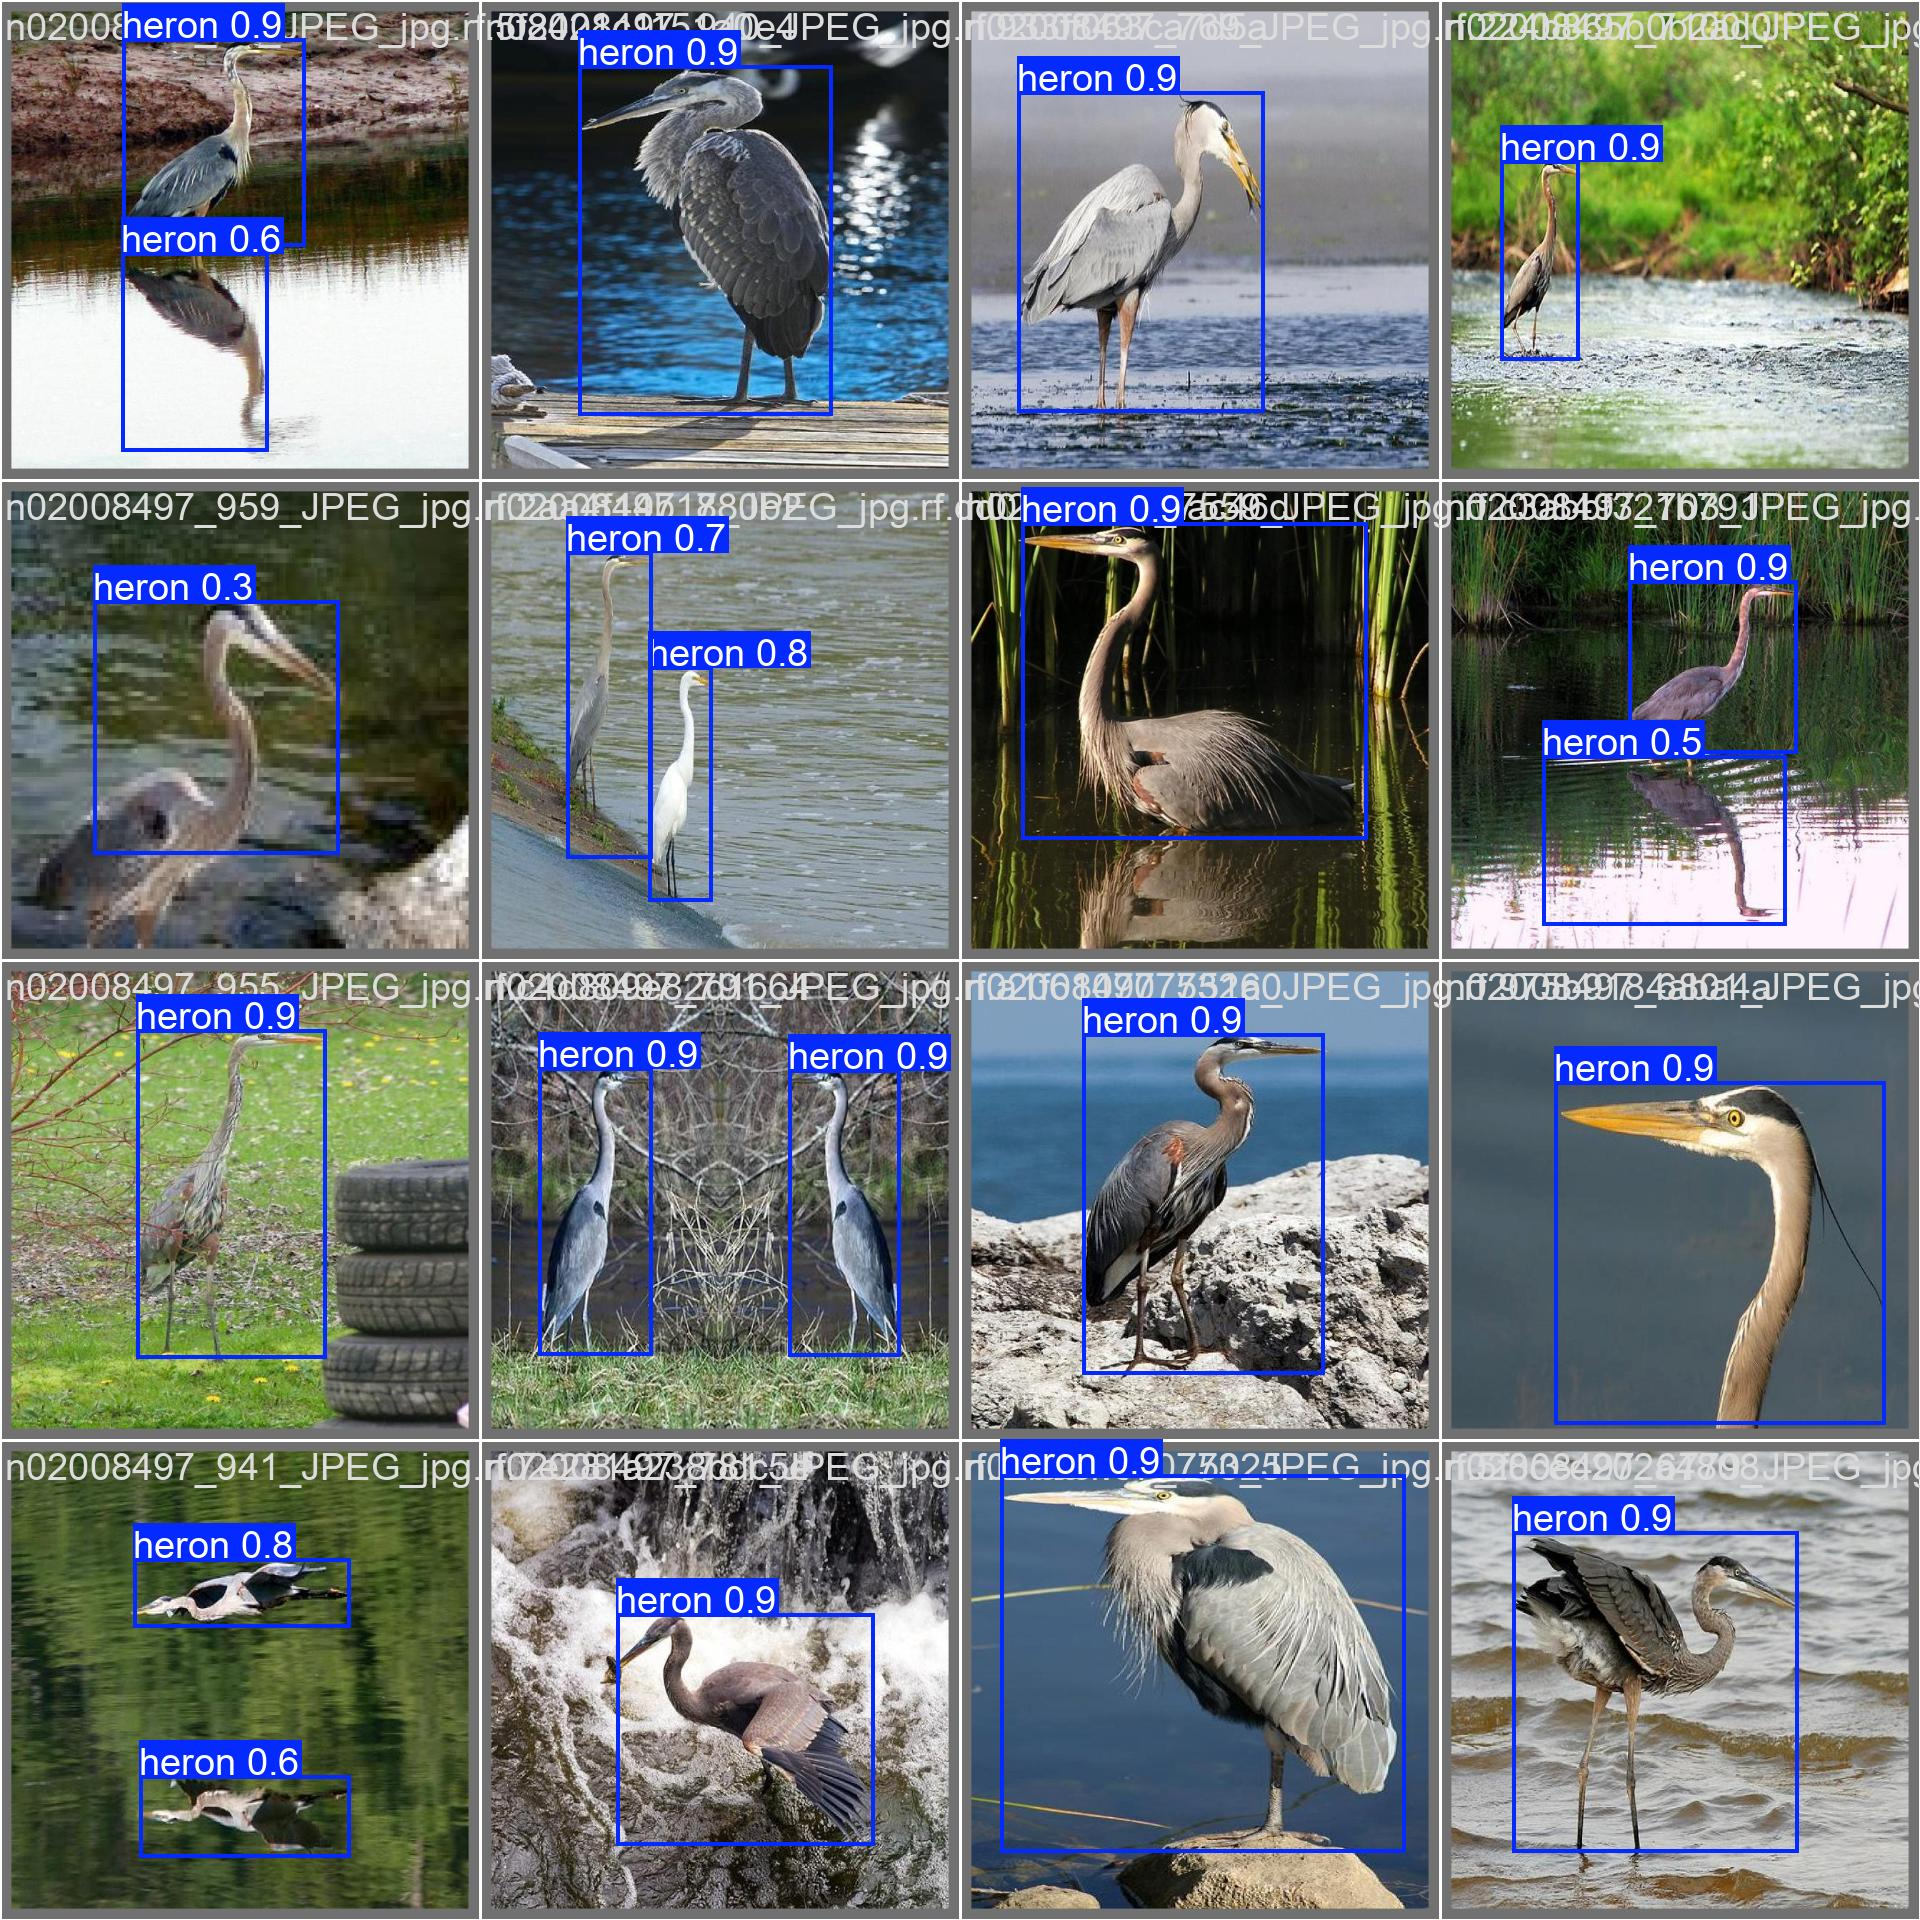

In [17]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [18]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/Blue-Heron-Raspberry-1/valid/labels.cache... 308 images, 0 backgrounds, 0 corrupt: 100% 308/308 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 20/20 [00:05<00:00,  3.86it/s]
                   all        308        338      0.951      0.919      0.973      0.832
Speed: 2.1ms preprocess, 9.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

In [19]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/154 /content/datasets/Blue-Heron-Raspberry-1/test/images/n02008497_1015_JPEG_jpg.rf.e9d2f8857d0762730ece22bc6cddfac6.jpg: 640x640 1 heron, 15.6ms
image 2/154 /content/datasets/Blue-Heron-Raspberry-1/test/images/n02008497_1041_JPEG_jpg.rf.f15bbef08056b30a2efe594ca90c9acd.jpg: 640x640 1 heron, 15.7ms
image 3/154 /content/datasets/Blue-Heron-Raspberry-1/test/images/n02008497_1150_JPEG_jpg.rf.ac30a4e52ebe83be75b026ac403f5c81.jpg: 640x640 1 heron, 15.6ms
image 4/154 /content/datasets/Blue-Heron-Raspberry-1/test/images/n02008497_1208_JPEG_jpg.rf.0cd1bc4acb38b6636f072a203b97f227.jpg: 640x640 1 heron, 15.6ms
image 5/154 /content/datasets/Blue-Heron-Raspberry-1/test/images/n02008497_1309_JPEG_jpg.rf.e4699454e1fb976af12adc4a2b473274.jpg: 640x640 1 heron, 15.6ms
image 6/154 /content/datasets/Blue-Heron-Raspberry-1/test/image

**NOTE:** Let's take a look at few results.

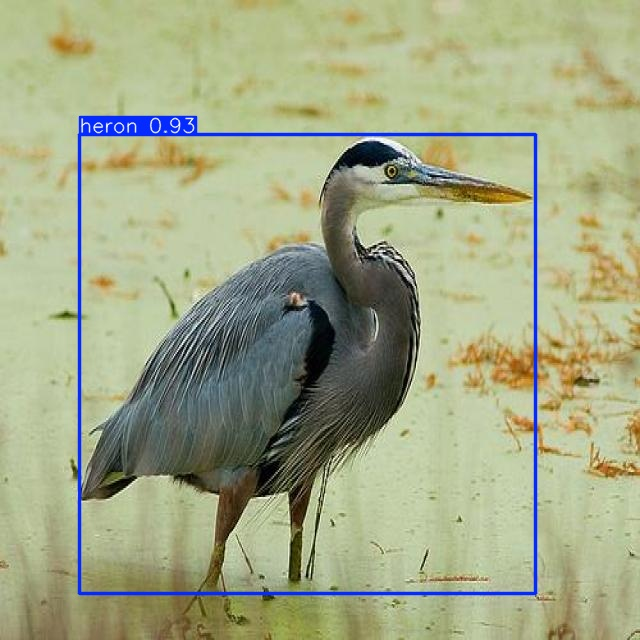

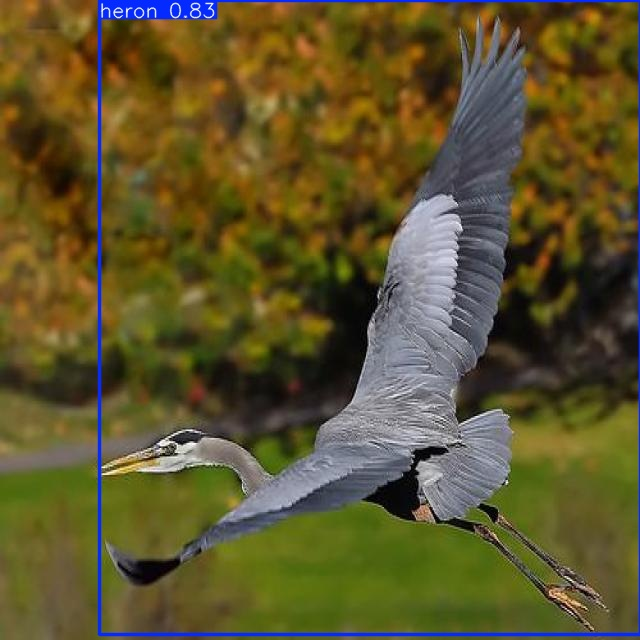

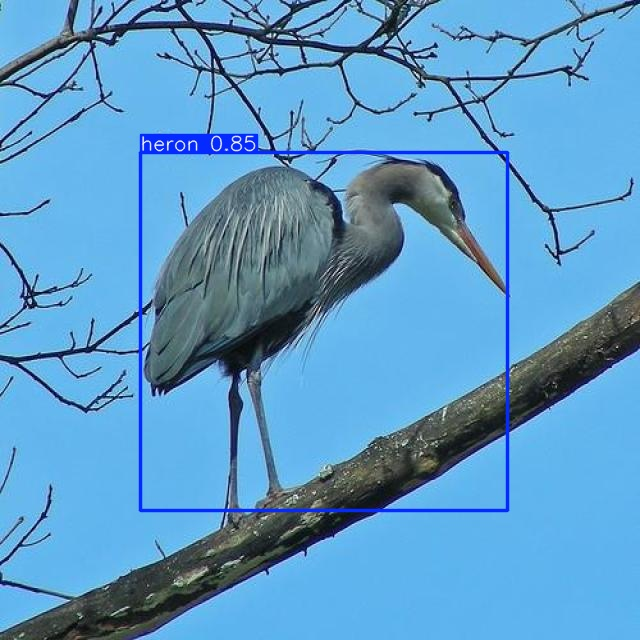

In [20]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [1]:
pip install -U ultralytics onnx2tf

In [2]:
from ultralytics import YOLO

# Laad je getrainde YOLOv11 model
# Zorg ervoor dat 'best.pt' in dezelfde directory staat als waar je dit script uitvoert,
# of geef het volledige pad naar 'best.pt' op.
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Exporteer het model naar TFLite (Float32)
# imgsz: De inputgrootte van het model. Gebruik dezelfde grootte als je training.
# nms: Voeg Non-Maximum Suppression (NMS) toe aan het model voor post-processing van detecties.
# int8: Stel in op False voor een Float32 model.
# Dit zal een 'best_float32.tflite' bestand aanmaken in de zelfde map.
model.export(format='tflite', imgsz=640, nms=False, int8=False)


WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (18.3 MB)
requirements: Ultralytics requirements ['ai-edge-litert>=1.2.0', 'onnxruntime', 'protobuf>=5'] not found, attempting AutoUpdate...

'/content/runs/detect/train/weights/best_saved_model/best_float32.tflite'

In [6]:
!yolo predict task=detect model=/content/runs/detect/train/weights/best_saved_model/best_float32.tflite imgsz=640 source=/content/datasets/Blue-Heron-Raspberry-1/test/images

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
E0000 00:00:1750336588.158154   21719 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750336588.164338   21719 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/nn/autobackend.py", line 445, in __init__
    from tflite_runtime.interpreter import Interpreter, load_delegate
ModuleNotFoundError: No module named 'tflite_runtime'

During handling of the above exception, another exception occurred:

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/nn/autobackend.py", line 445, in __init__
    from tflite_runtime.int

In [7]:
!yolo val task=detect model=/content/runs/detect/train/weights/best_saved_model/best_float32.tflite imgsz=640 data=/content/datasets/Blue-Heron-Raspberry-1/data.yaml

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
E0000 00:00:1750336683.839659   22131 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750336683.846058   22131 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/nn/autobackend.py", line 445, in __init__
    from tflite_runtime.interpreter import Interpreter, load_delegate
ModuleNotFoundError: No module named 'tflite_runtime'

During handling of the above exception, another exception occurred:

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/nn/autobackend.py", line 445, in __init__
    from tflite_runtime.int